# Predykcja cen nieruchomości oparta na modelu maszyny wektorów nośnych

## Wstęp

Celem niniejszego projektu będzie zaimplemetowanie trzech regresorów służących do predykcji ceny domu, opartych na modelu maszyny wektorów nośnych (SVM), bazujących na kernelu:
1. liniowym
2. wielomianowym
3. RBF. 

Dokumentacja będzie skupiała się na opisie rozwiązania problemu przewidywania cen nieruchomości z perspektywy potencjalnego kupującego oraz sprzedającego. Zebrane dane dotyczą obszarów położonych wokół amerykańskiego miasta Boston i pochodzą z 1974 roku. 

Model przewidujący cene rynkową nieruchomości mógłby być znakomitym narzędziem w rękach agenta, którego praca opiera się na analizach wartości domów. Z drugiej strony, potencjalny nabywca również mógłby wykorzystać model, aby zorientować się, w jakim przedziale cenowym nieruchomość, którą jest zainteresowany, się znajduje.

Na cene domu, oprócz takich cech jak powierzchnia użytkowa i lokalizacja, wpływ ma wiele mniej oczywistych cech. W projektowanym modelu zostanie podjęta próba wykorzystania wszystkich użytecznych informacji w celu przeprowadzenia pełnej analizy i oszacowaniu cen nieruchomości.

Cały etap projektowania modelu podzielony został na etapy, które umożliwią zoptymalizowanie danych pod kątem logicznym, tak, aby możliwe stało się ich jak najlepsze wykorzystanie w celach predykcji. Tymi krokami są:

1. Zaimportowanie danych oraz bibliotek
2. Analiza cechy predykowanej - ceny nieruchomości
3. Analiza cech nieruchomości
4. Imputacja brakujących danych oraz wyczyszczenie danych
5. Optymalizacja danych
6. Budowa modelu i predykcja

# 1. Zaimportowanie danych oraz bibliotek

## 1.1 Zaimportowanie bibliotek

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

Na początku zaimportowane zostaną wszystkie biblioteki, dzięki którym znacząco ułatwiony zostanie proces analizowania danych. Wśród nich znajdują się biblioteki:

1. Pandas - jest opensource'ową biblioteką, wydawaną na licencji BSD, która dostarcza zaawansowanych mechanizmów tworzenia struktur danych oraz ich analizy w języku Python;
2. NumPy - jest podstawową bilblioteką wykorzystywaną w obliczeniach inżynierskich wykonywanych w Pythonie. Dostarcza mechanizmów tworzenia N-wymiarowych tablic, skomplikowanych funkcji matematycznych oraz integracji z kodami źródłowymi napisanymi w językach C/C++ oraz Fortran. Jednak najważniejszą funkcjonalnością pozostaje możliwość tworzenia kontenerów danych w celach ich późniejszej analizy.
3. Seaborn - jest biblioteką, opartą o pakiet matplotlib, umożliwiającą wizualizacje danych i analiz w Pythonie na zaawansowanym poziomie
4. matplotlib - ta biblioteka dostarcza mechanizmów rysowania gotowych do publikacji wykresów w wielu ogólnodostępnych formatach oraz w wielu środowiskach, w tym w wykorzystywanym w projekcie Jupyter Notebook.
6. SciPy - dostarcza wielu mechanizmów, które umożliwiają na wykonanie często używanych operacji numerycznych, jak integracja, interpolacja, optymalizacja czy statystyka
7. scikit-learn - jedna z najważniejszych bibliotek, która dostarcza mechanizmów sztucznej inteligencji w języku Python. Zawiera implmenetacje alogrytmów klasyfikacji, regresji oraz klasteryzacji opartych na metodach gradientowego wzmacniania regrecji, lasów losowych czy wykorzystywanych w projekcie maszynach wektorów nośnych. Dodatkowo jest kompatybilna i współpracuje razem z bibliotekami SciPy oraz NumPy

## 1.2 Zaimportowanie danych

In [2]:
# Load train and Test set
train = pd.read_csv("./boston-housing/train.csv")
test = pd.read_csv("./boston-housing/test.csv")

W dwóch plikach .csv zawarte są dane, które zostaną wykorzystane w celach budowy modeli regresorów. Dane pochodzą z repoztorium uczenia maszynowego UCI. Zostały zebrane w roku 1978 i zawierają 506 rekordów przedstawiających zagregowane informacje o średnich cenach nieruchomości w poszczególnych obszarach oraz związanych z nimi cechach.

In [3]:
# Check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# Save the 'Id' column
train_ID = train['ID']
test_ID = test['ID']

# Now drop the 'Id' column since it's unnecessary for the prediction process.
train.drop("ID", axis = 1, inplace = True)
test.drop("ID", axis = 1, inplace = True)

# Check data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (333, 15) 
The test data size before dropping Id feature is : (173, 14) 

The train data size after dropping Id feature is : (333, 14) 
The test data size after dropping Id feature is : (173, 13) 


Można zauwazyć, że dane z pliku train.csv zawierają jedną kolumne więcej niż dane z pliku test.csv. Tą kolumną jest średnia cena nieruchomości, którą model ma za zadanie przewidzieć. 

Kolumna, informująca o identyfikatorze poszczególnych rekordów, zostanie na czas analizy i budowania modelu odłączona od danych.

In [4]:
train.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [5]:
test.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
1,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21
2,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15
3,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93
4,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10


Cechami, które opisują każdą z nieruchomości w zaimportowanych danych są:
1. crim - współczynnik przestępstw per capita w danym mieście
2. zn - proporcja strefy gruntów mieszkalnych z mieszkaniami powyżej 25.000 stóp kwadratowych
3. indus - proporcja działalności niehandlowwej w danym mieście
4. chas - cecha określająca przyleganie nieruchomości do rzeki Charles (= 1 gdy przylega do rzeki, 0 w przeciwnym wypadku
5. nox - koncentracja tlenku azotu (w cząsteczkach na 10 milionów)
6. rm - średnia liczba pokoi na nieruchomość
7. age - proporcja nieruchomości zajętych wybudowanych po 1940 roku
7. dis - średnia ważona odległości od 5 największych bostońskich centrów zatrudnienia
8. rad - index określający dostępność nieruchomości do autostrad
9. tax - stopa podatku od nieruchomości per 10.000 dolarów
10. ptratio - stosunek liczby uczniów do nauczycieli w danym mieście
11. black - 1000(Bk - 0.63)^2 gdzie Bk to stosunek czarnoskórych w danym mieście
12. lstat - procent populacji żyjący poniżej granicy ubóstwa
13. medv - średnia wartość nieruchomości w 1000 dolarów

Należy pamiętać, że poszczególne cechy są średnimi wartościami, zebranymi spośród nieruchomości na danym obszarze.

# 2. Analiza cechy predykowanej - ceny nieruchomości 

W tym rozdziale przeprowadzona zostanie analiza ceny nieruchomości - cechy, którą model ma za zadanie predykować.

In [6]:
# Getting Description
train['medv'].describe()

count    333.000000
mean      22.768769
std        9.173468
min        5.000000
25%       17.400000
50%       21.600000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

Powyżej przedstawione są statystyki cen nieruchomości w obszarze Bostonu. Ciekawą obserwacją jest fakt, że górny kwartyl wynosi 250.000 dolarów, a średnia jest niewiele mniejsza - około 230.000 dolarów. Wiele z rekordów posiada w kolumnie 'medv' wartość 500.000$, co może świadczyć o błędzie utraty danych lub ocenzurowaniu.

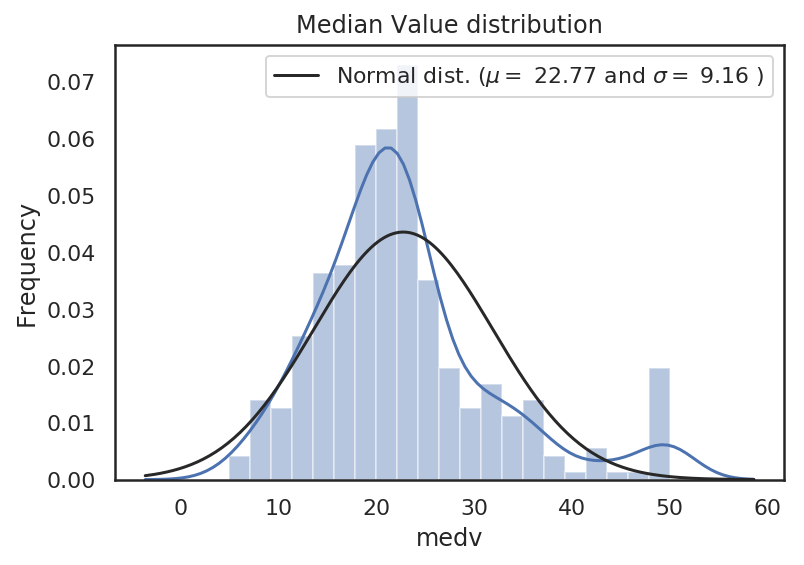

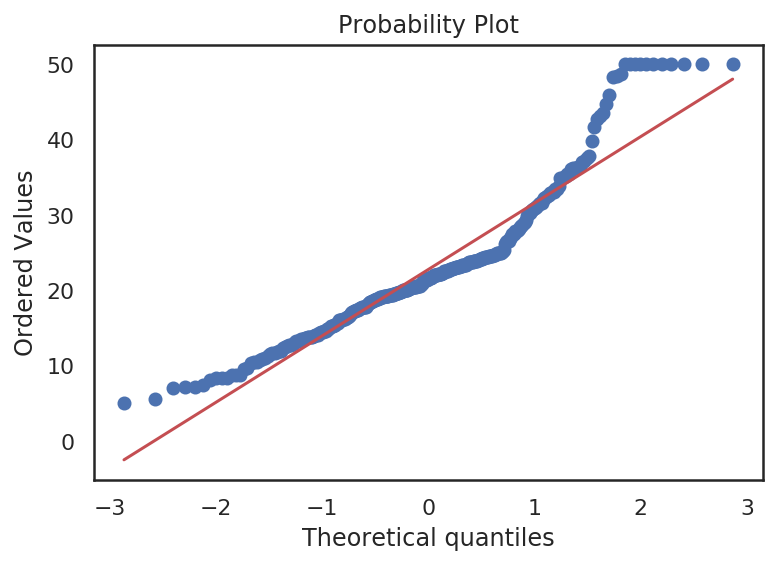

Skewness: 1.122472
Kurtosis: 1.558037


In [7]:
# Plot Histogram
sns.distplot(train['medv'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['medv'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Median Value distribution')

fig = plt.figure()
res = stats.probplot(train['medv'], plot=plt)
plt.show()

print("Skewness: %f" % train['medv'].skew())
print("Kurtosis: %f" % train['medv'].kurt())

Doskonale widać nienatualne zachowanie danych na wykresach rozkładu wartości. Zbyt wiele rekordów osiąga bariere 500.000 dolarów. Zauważyć również można, że rozkład jest zdecydowanie za bardzo przesunięty w lewo oraz zbyt skoncentrowany, o czym świadczą wartości współczynnika skośności oraz kurtozy.

Na dalszych etapach projektu dane zostaną odpowiednio zmodyfikowane, tak, aby uzyskać rozkład jak najbardziej zbliżony do normalnego.

# 3. Analiza cech nieruchomości

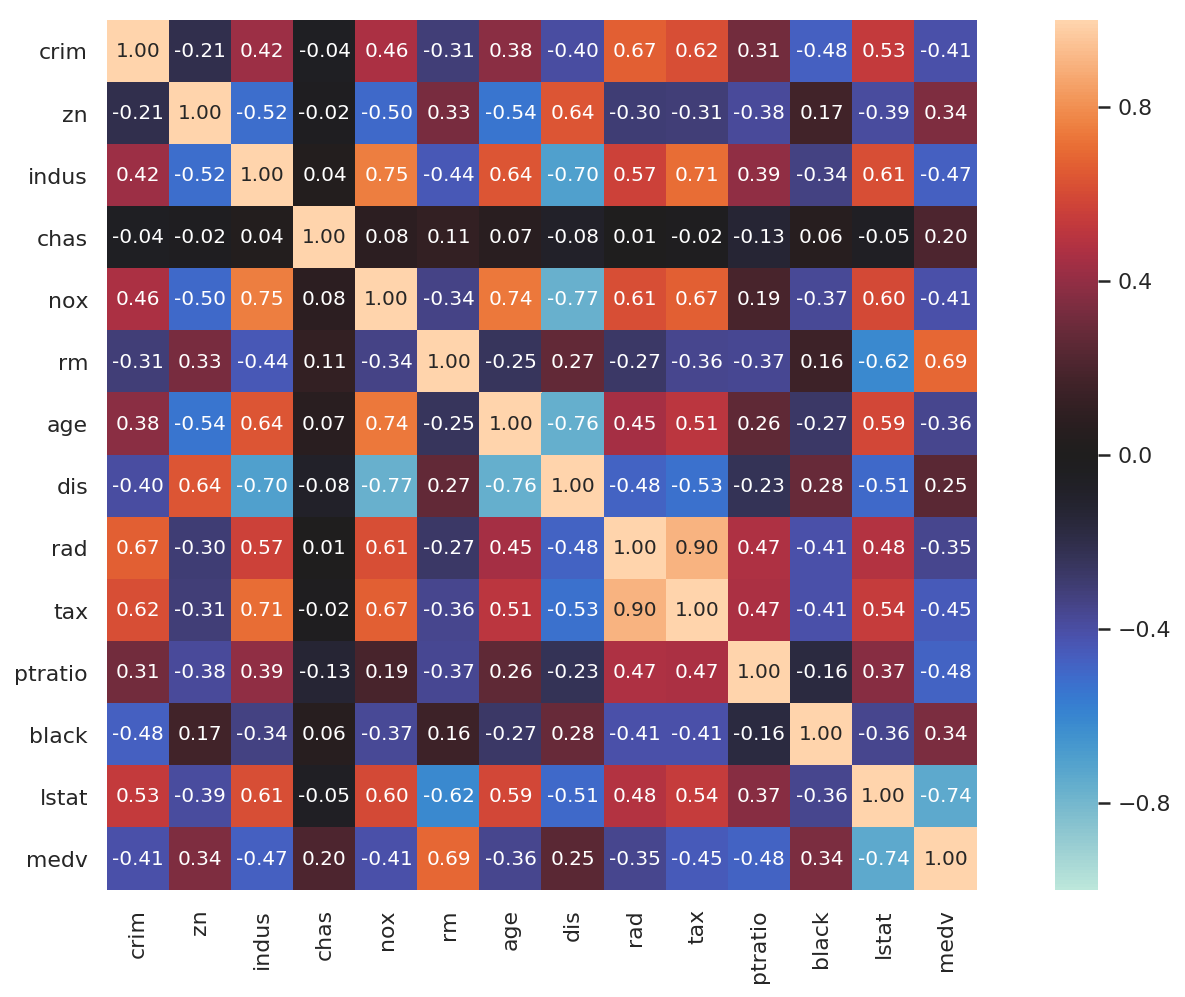

In [8]:
# Correlation Matrix Heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corrmat, vmin=-1, vmax=1, square=True, center=0, annot=True, fmt='.2f');

Powyżej przedstawiona została macierz korelacji. Mówi ona jak bardzo poszczególne cechy nieruchomości korelują ze sobą. Najbardziej interesującym elementem macierzy jest wiersz korelacji wartości nieruchomości z resztą cech. 

In [9]:
cols = corrmat.abs().nlargest(14, 'medv')['medv'].index
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,medv
1,lstat
2,rm
3,ptratio
4,indus
5,tax
6,nox
7,crim
8,age
9,rad


Powyższe zestawienie przedstawia cechy, uszeregowane według wielkości wpływu na wycene lokum.

Cechami, które najbardziej wpływają na ostateczną wycene wartości nieruchomości są przede wszystkim:
1. lstat - będąca miarą ubóstwa w okolicy. Ludzie niechętnie zamieszkują okolice, gdzie poziom zamożności ludzi jest niski. Może to powodować rozwój różnego rodzaju patologii, w tym wzrost przestępczości.
2. rm - średnia liczba pokoi na nieruchomość. Wieksza liczba pokoi oznacza większą powierzchnie lokum, co przekłada się bezpośrednio na jego cenę. Jednak należy mieć na uwadze fakt, że liczba pokoi nie przekłada się liniowo na większą powierzchnie nieruchomości - istnieją przypadki mieszkań o 2-3 wielkopowierzchniowych pokojach.
3. ptratio - stosunek liczby uczniów do czynnych zawodowo nauczycieli jest dobrym wyznacznikiem jakości szkolnictwa w danej okolicy. Logicznym wydaje się być wzrost ceny nieruchomości wraz z możliwością zapewnienia dziecku lepszego wykształcenia.
4. indus - będąca miarą zindustralizowania okolicy. Ludzie niechętnie zamieszkują obszary, w których poziom zanieczyszczeń i hałasu jest wysoki, a infrastuktura przyrodnicza jest słabo rozwinięta. Ceny nieruchomości w pobliżu fabryk czy centrów przemysłowych są niższe.
5. tax - określająca wysokość podatku od nieruchomości w danej okolicy. Logicznym wydaje się być fakt, że ceny domów w okolicy, gdzie podatki są stosunkowo wysokie, będą niższe niż w okolicy, gdzie te podatki są niższe.

## 3.1 Cechy nie mające wpływu na cene nieruchomości

Podczas analizy danych dostarczonych z repozytorium, natrafiono na cechy, które mają znikomy lub żaden wpływ na ostateczną wycene nieruchomości. Tego typu cechy powinny zostać zoptymalizowane lub usunięte. Cechy, które zwiększają wymiary modelu oraz jego skomplikowanie, nie wpływając jednocześnie na polepszenie jakości predykcji, sprawiają, że model może pogorszyć swoją skuteczność.

### Blacks

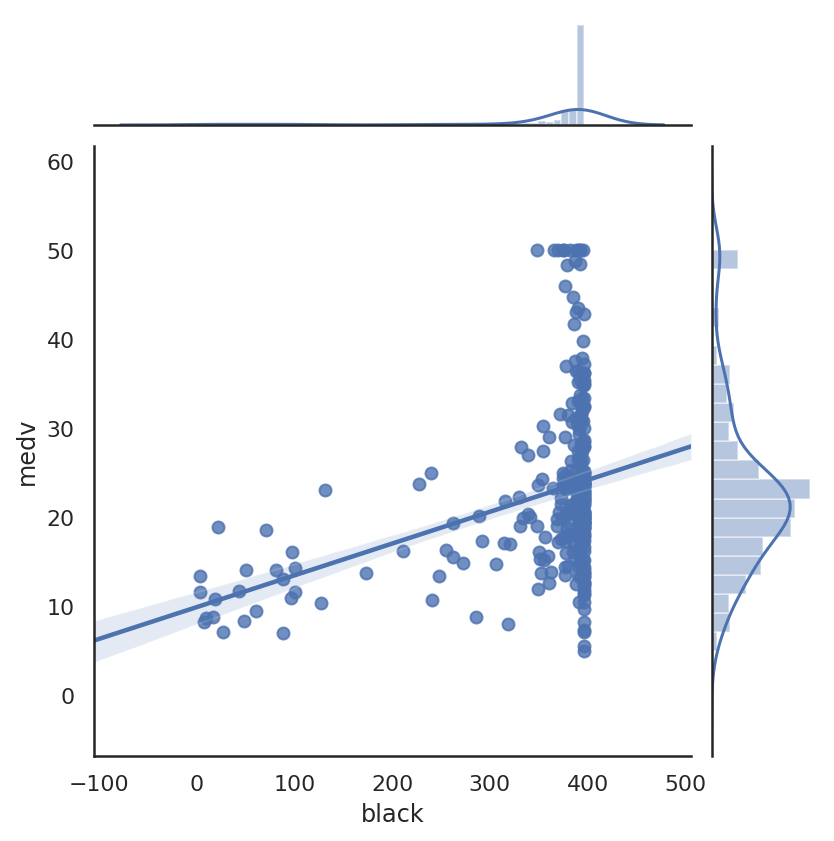

In [10]:
sns.jointplot(x=train['black'], y=train['medv'], kind='reg');

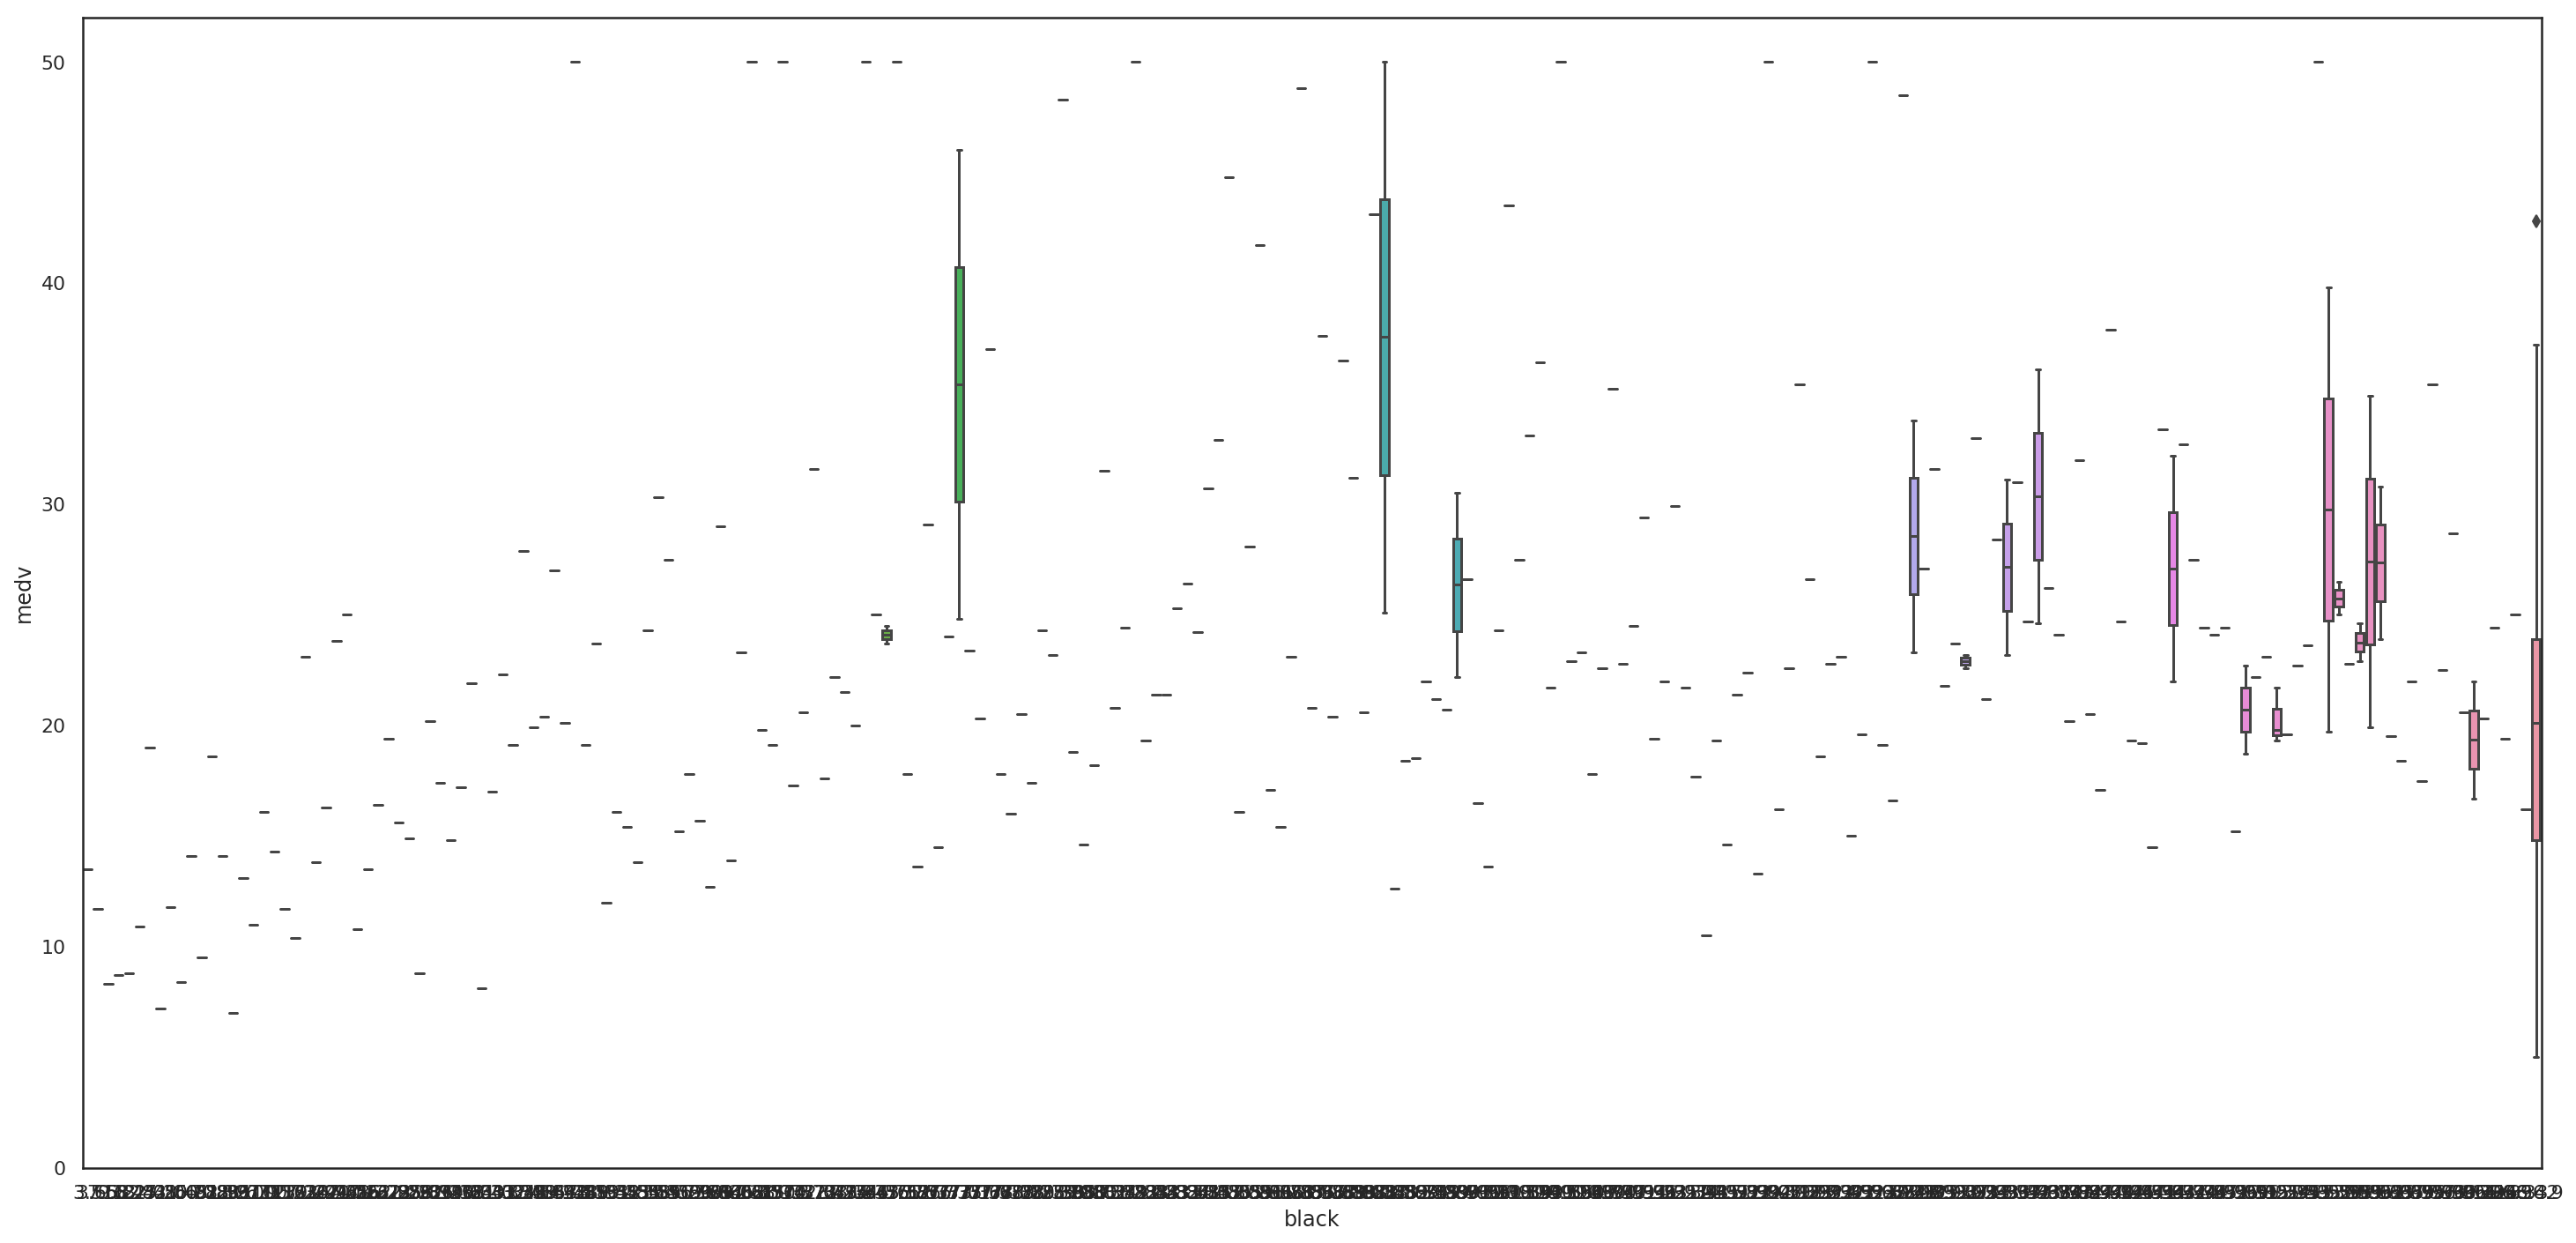

In [11]:
var = 'black'
data = pd.concat([train['medv'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(25, 12))
fig = sns.boxplot(x=var, y="medv", data=data)
fig.axis(ymin=0, ymax=52);

Na podstawie powyższych wykresów można wysnuć wniosek, że tak określona cecha stosunku czarnoskórej ludności do pozostałej nie wywiera żadnego wpływu na cene nieruchomości. Niezależnie od tego, czy stosunek ten jest wysoki czy niski, ceny domów mogą być zarówno wysokie jak i bardzo niskie.

In [12]:
# deleting non-affecting data
train.drop(['black'], axis=1, inplace=True)
test.drop(['black'], axis=1, inplace=True)

Zdecydowano, że w celu podniesienia jakości modelu, cecha 'Black' zostanie usunięta z danych.

### Chas

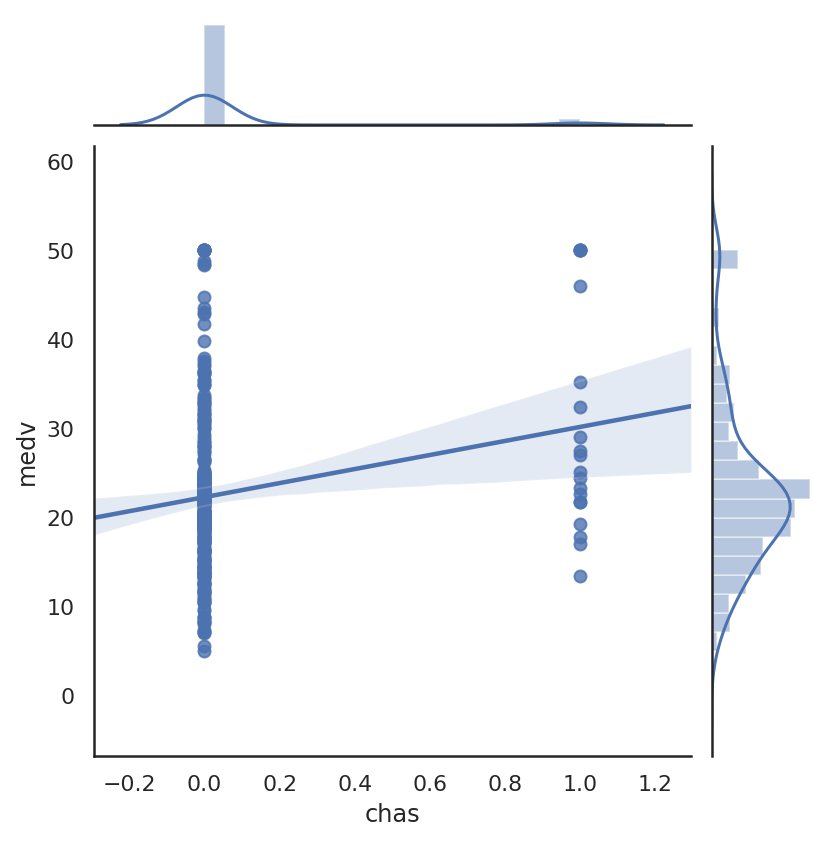

In [13]:
sns.jointplot(x=train['chas'], y=train['medv'], kind='reg');

Po raz kolejny zauważyc można znikomy wpływ cechy. Tym razem informacja o przyleganiu nieruchomości do koryta rzeki Charles nie ma żadnego wpływu na ostateczną wartość domu. Powodem tego może być również zero-jedynkowy opis cechy. Możliwe, że reprezentacja cechy w postaci odległości od rzeki w jenostkach długości niosłaby ze sobą większy wpływ na cene nieruchomości.

In [14]:
# deleting non-affecting data
train.drop(['chas'], axis=1, inplace=True)
test.drop(['chas'], axis=1, inplace=True)

Podobnie jak z cechą 'Black', zdecydowano, że w celu podniesienia jakości modelu, cecha 'Chas' zostanie usunięta z danych.

## 3.2 Cechy mające największy wpływ na cene nieruchomości

W tym podrozdziale przeprowadzone zostaną analizy cech, które najbardziej korelują ze średnią ceną nieruchomości w danym obszarze. Analiza przeprowadzona zostanie na 5 najważniejszych cechach:
1. lstat
2. rm
3. ptratio
4. indus
5. tax

### lstat

(-0.7386000348786337, 1.2283469073773686e-58)


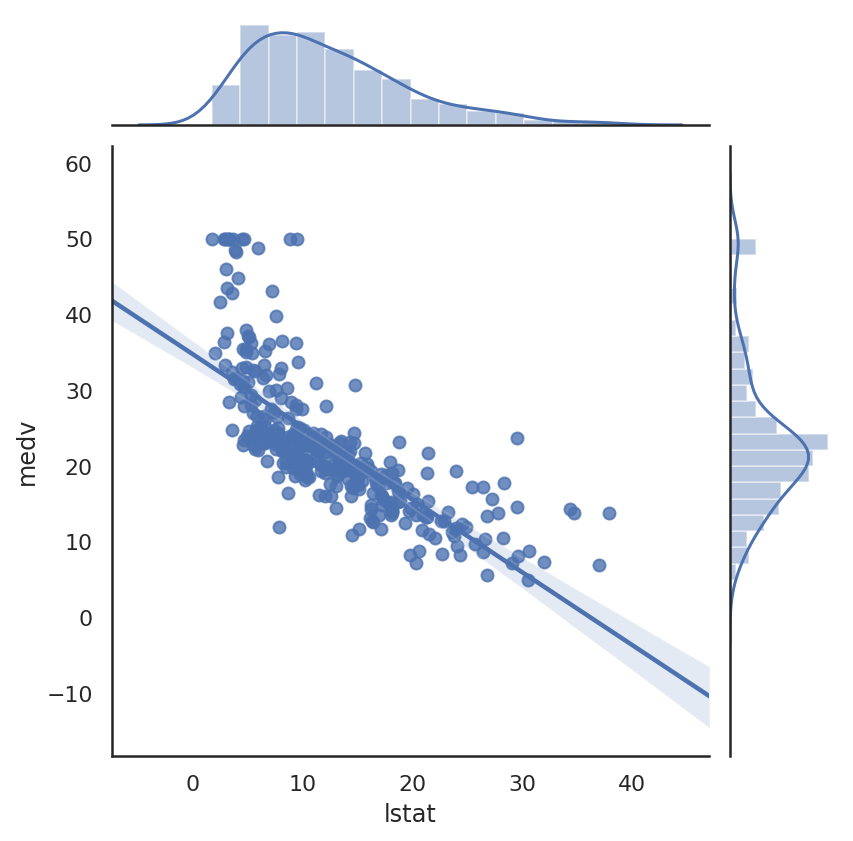

In [15]:
sns.jointplot(x=train['lstat'], y=train['medv'], kind='reg');
print(pearsonr(train['lstat'], train['medv']));

Jak wspomniano na początku rozdziału, logicznym jest fakt, że ludzie chętniej zamieszkują obszary, w których poziom ubóstwa jest niski. Co wzbudza niepokój podczas analizy to dwa elementy odstające, dla których wartość nieruchomości została wyceniona na 500.000 dolarów, przy jednoczesnym stosunkowo wysokim poziomie ubóstwa.

In [16]:
# Removing outliers manually 
train = train.drop(train[(train['medv']>49.99) & (train['lstat']>8)].index).reset_index(drop=True)

Zdecydowano na usunięcie dwóch rekordów z danych.

(-0.7509923613803439, 2.908115274300203e-61)


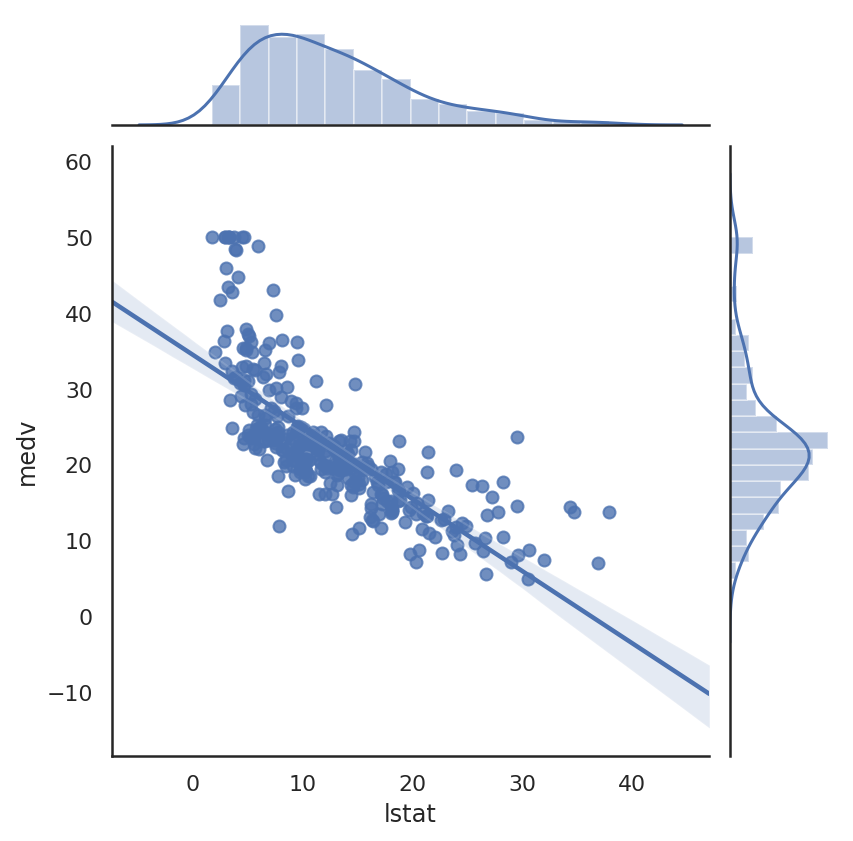

In [17]:
sns.jointplot(x=train['lstat'], y=train['medv'], kind='reg');
print(pearsonr(train['lstat'], train['medv']));

Dzięki usunięciu dwóch skrajnych punktów współczynnik korelacji Pearsona zmniejszył się o ponad 0.01, co jest wynikem satysfakcjonującym.

### rm

(0.7149039303166089, 4.634703062011877e-53)


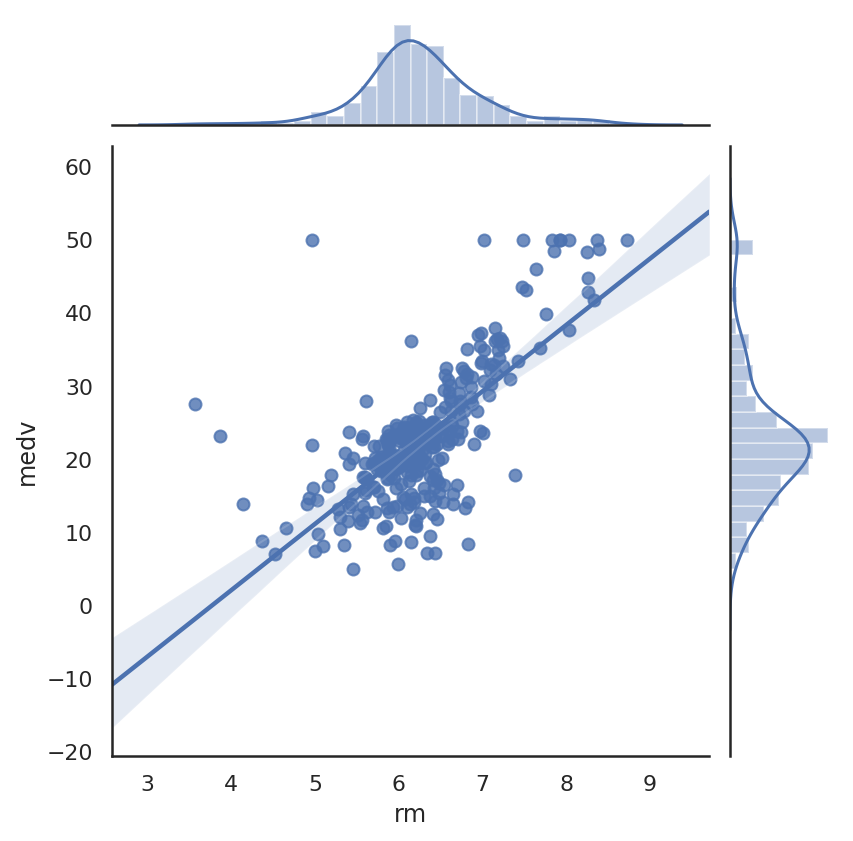

In [18]:
sns.jointplot(x=train['rm'], y=train['medv'], kind='reg');
print(pearsonr(train['rm'], train['medv']));

Zgodnie z poprzednimi obserwacjami, oczywsitym wydaje się fakt, że większa liczba pokoi w domu zwiększa jego wartość rynkową.

Należy jednak przeanalizować obserwacje odstające. Istnieją przypadki, w których pomimo średniej liczby pokoi przypadających na lokum wynoszącej 5, ich cena jest wyjątkowo wysoka. Wpływ na to może mieć rozmiar pokoi, który nie został uwzględniony w cecach, a który może sprawiać, że duży drogi dom ma niewielką liczbe pokoi.

In [19]:
train = train.drop(train[(train['medv'] > 8 * train['rm'] - 8)].index).reset_index(drop=True)

W związku z brakiem cechy określającej wielkość nieruchomości, zdecydowano odrzucić odstające obserwacje, dla których stosunek wartości do liczby pokoi był zaburzony.

(0.7896995647350031, 6.105256290139437e-71)


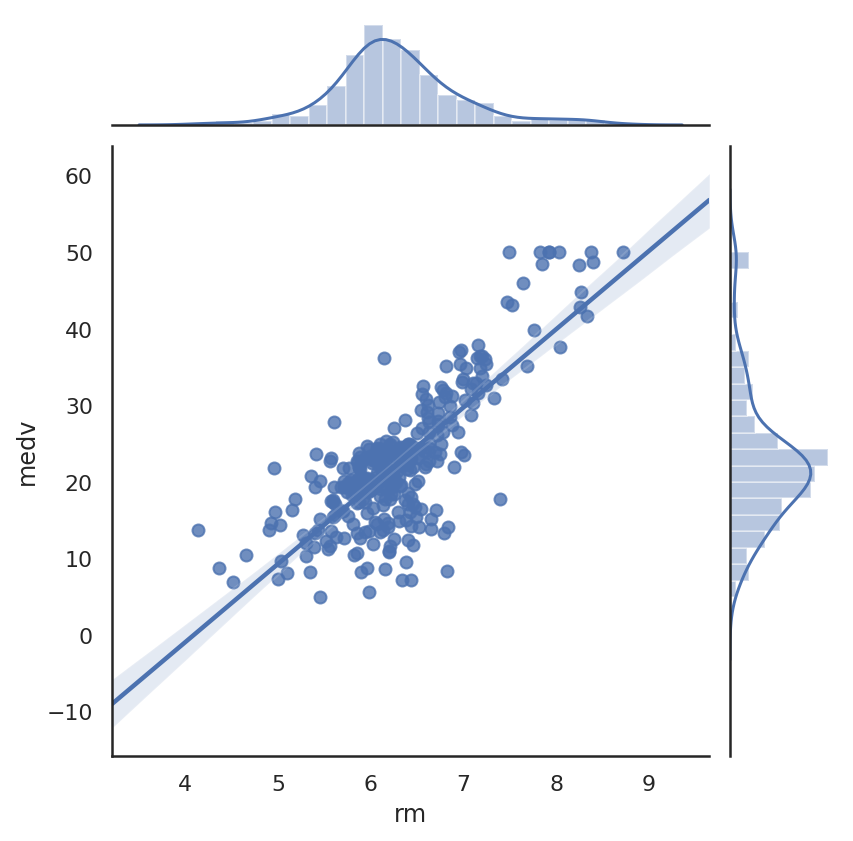

In [20]:
sns.jointplot(x=train['rm'], y=train['medv'], kind='reg');
print(pearsonr(train['rm'], train['medv']));

Odrzucenie tych obserwacji umożliwiło nam zwiększenie współczynnika korelacji o 0.04, co jest bardzo dobrym wynikiem

### ptratio

(-0.5460018117433976, 8.38139991285211e-27)


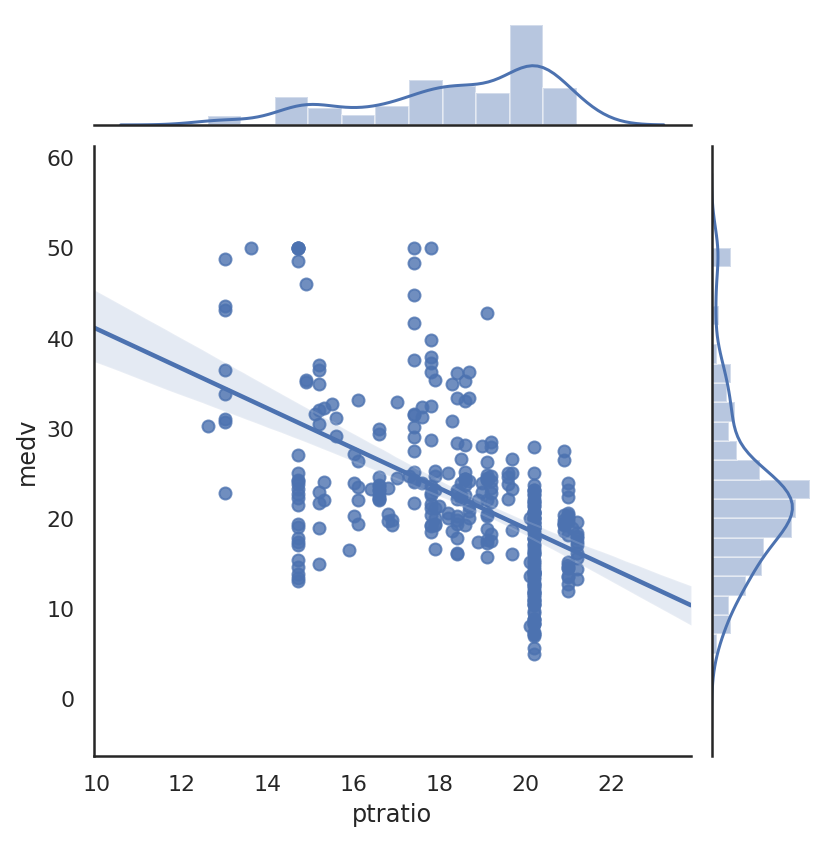

In [21]:
sns.jointplot(x=train['ptratio'], y=train['medv'], kind='reg');
print(pearsonr(train['ptratio'], train['medv']));

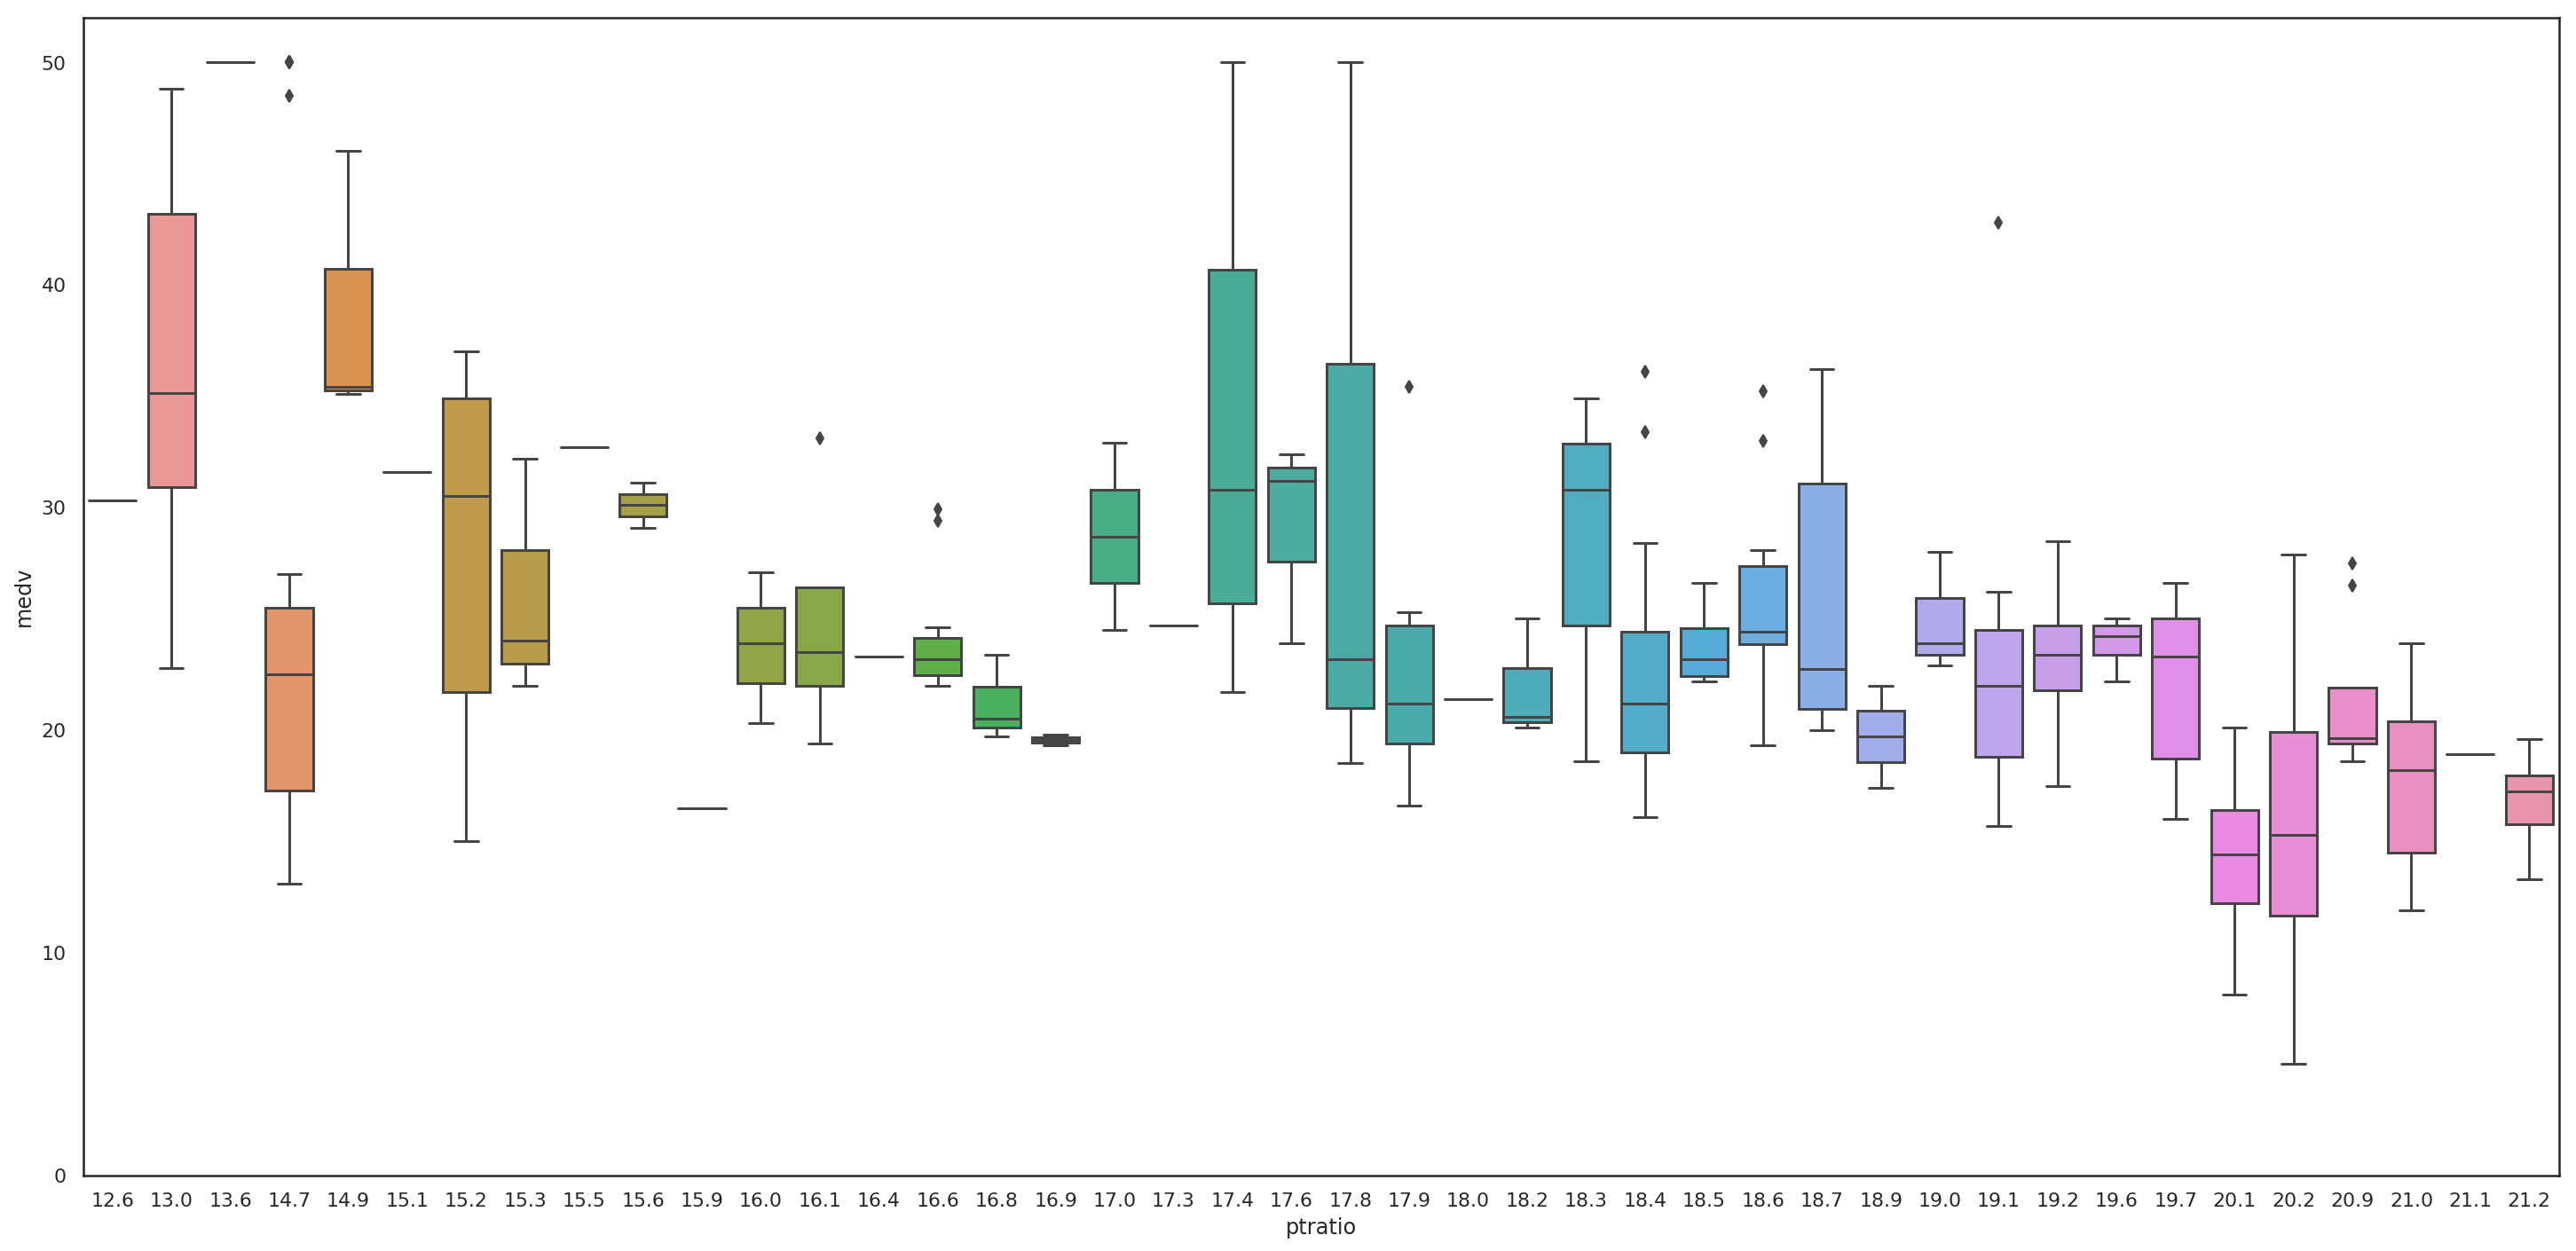

In [22]:
var = 'ptratio'
data = pd.concat([train['medv'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(25, 12))
fig = sns.boxplot(x=var, y="medv", data=data)
fig.axis(ymin=0, ymax=52);

Na pierwszy rzut oka dane wydają się być dość chaotycznie rozłożone. Jednak na wykresie ramkowym można zaobserwować tendencje do spadku wartości nieruchomości wraz ze zwiększaniem się stosunku liczby uczniów do nauczycieli, co jest potwierdzeniem początkowych obserwacji z niniejszego rozdziału.

Jednakże występują również elementy odstające, dla których, pomimo stosunkowo wysokiego współczynnika 'ptratio', wartość średnia nieruchomości została określona na wysokim poziomie. Wytłumaczeniem dla tego zjawiska może być fakt, że statystyka 'ptratio' określana jest nie dla konkretnego regionu, a miasta. Można wyobrazić sobie sytuację, w której w jednym mieście znajduje się kilka regionów o różnej charakterystyce - skrajnie bogatych i skrajnie biednych, dla których współczynik liczby uczniów do liczby nauczycieli jest wspólny.

Podsumowując, pomimo, że dane mają nienaturalny rozkład, nie odrzucono żadnych obserwacji.

### indus

(-0.5459465607349125, 8.500130020350649e-27)


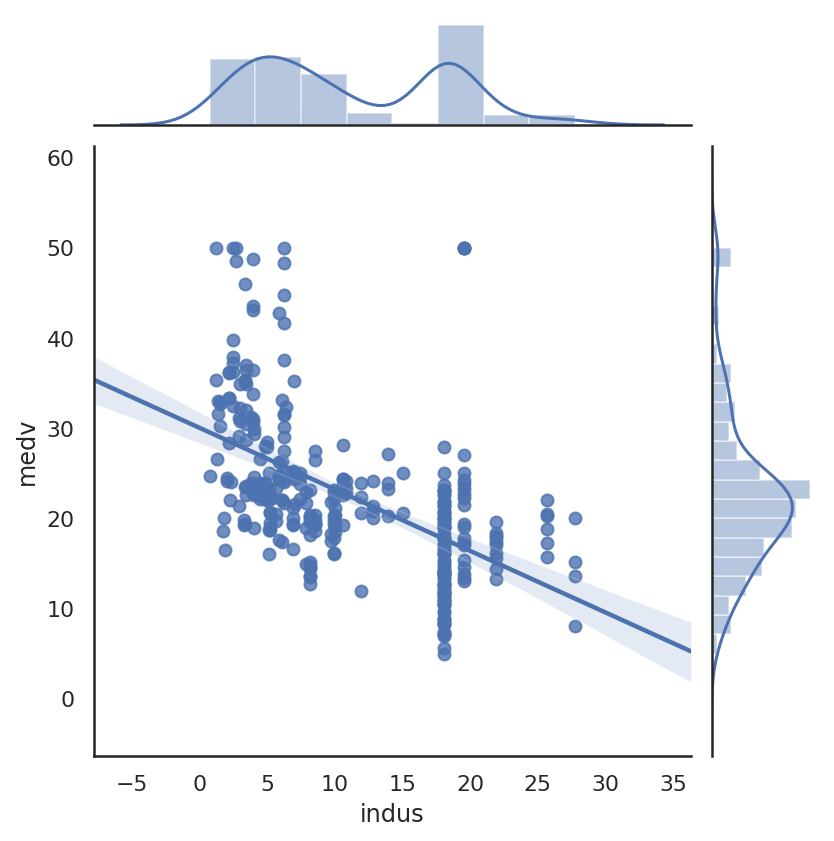

In [23]:
sns.jointplot(x=train['indus'], y=train['medv'], kind='reg');
print(pearsonr(train['indus'], train['medv']));

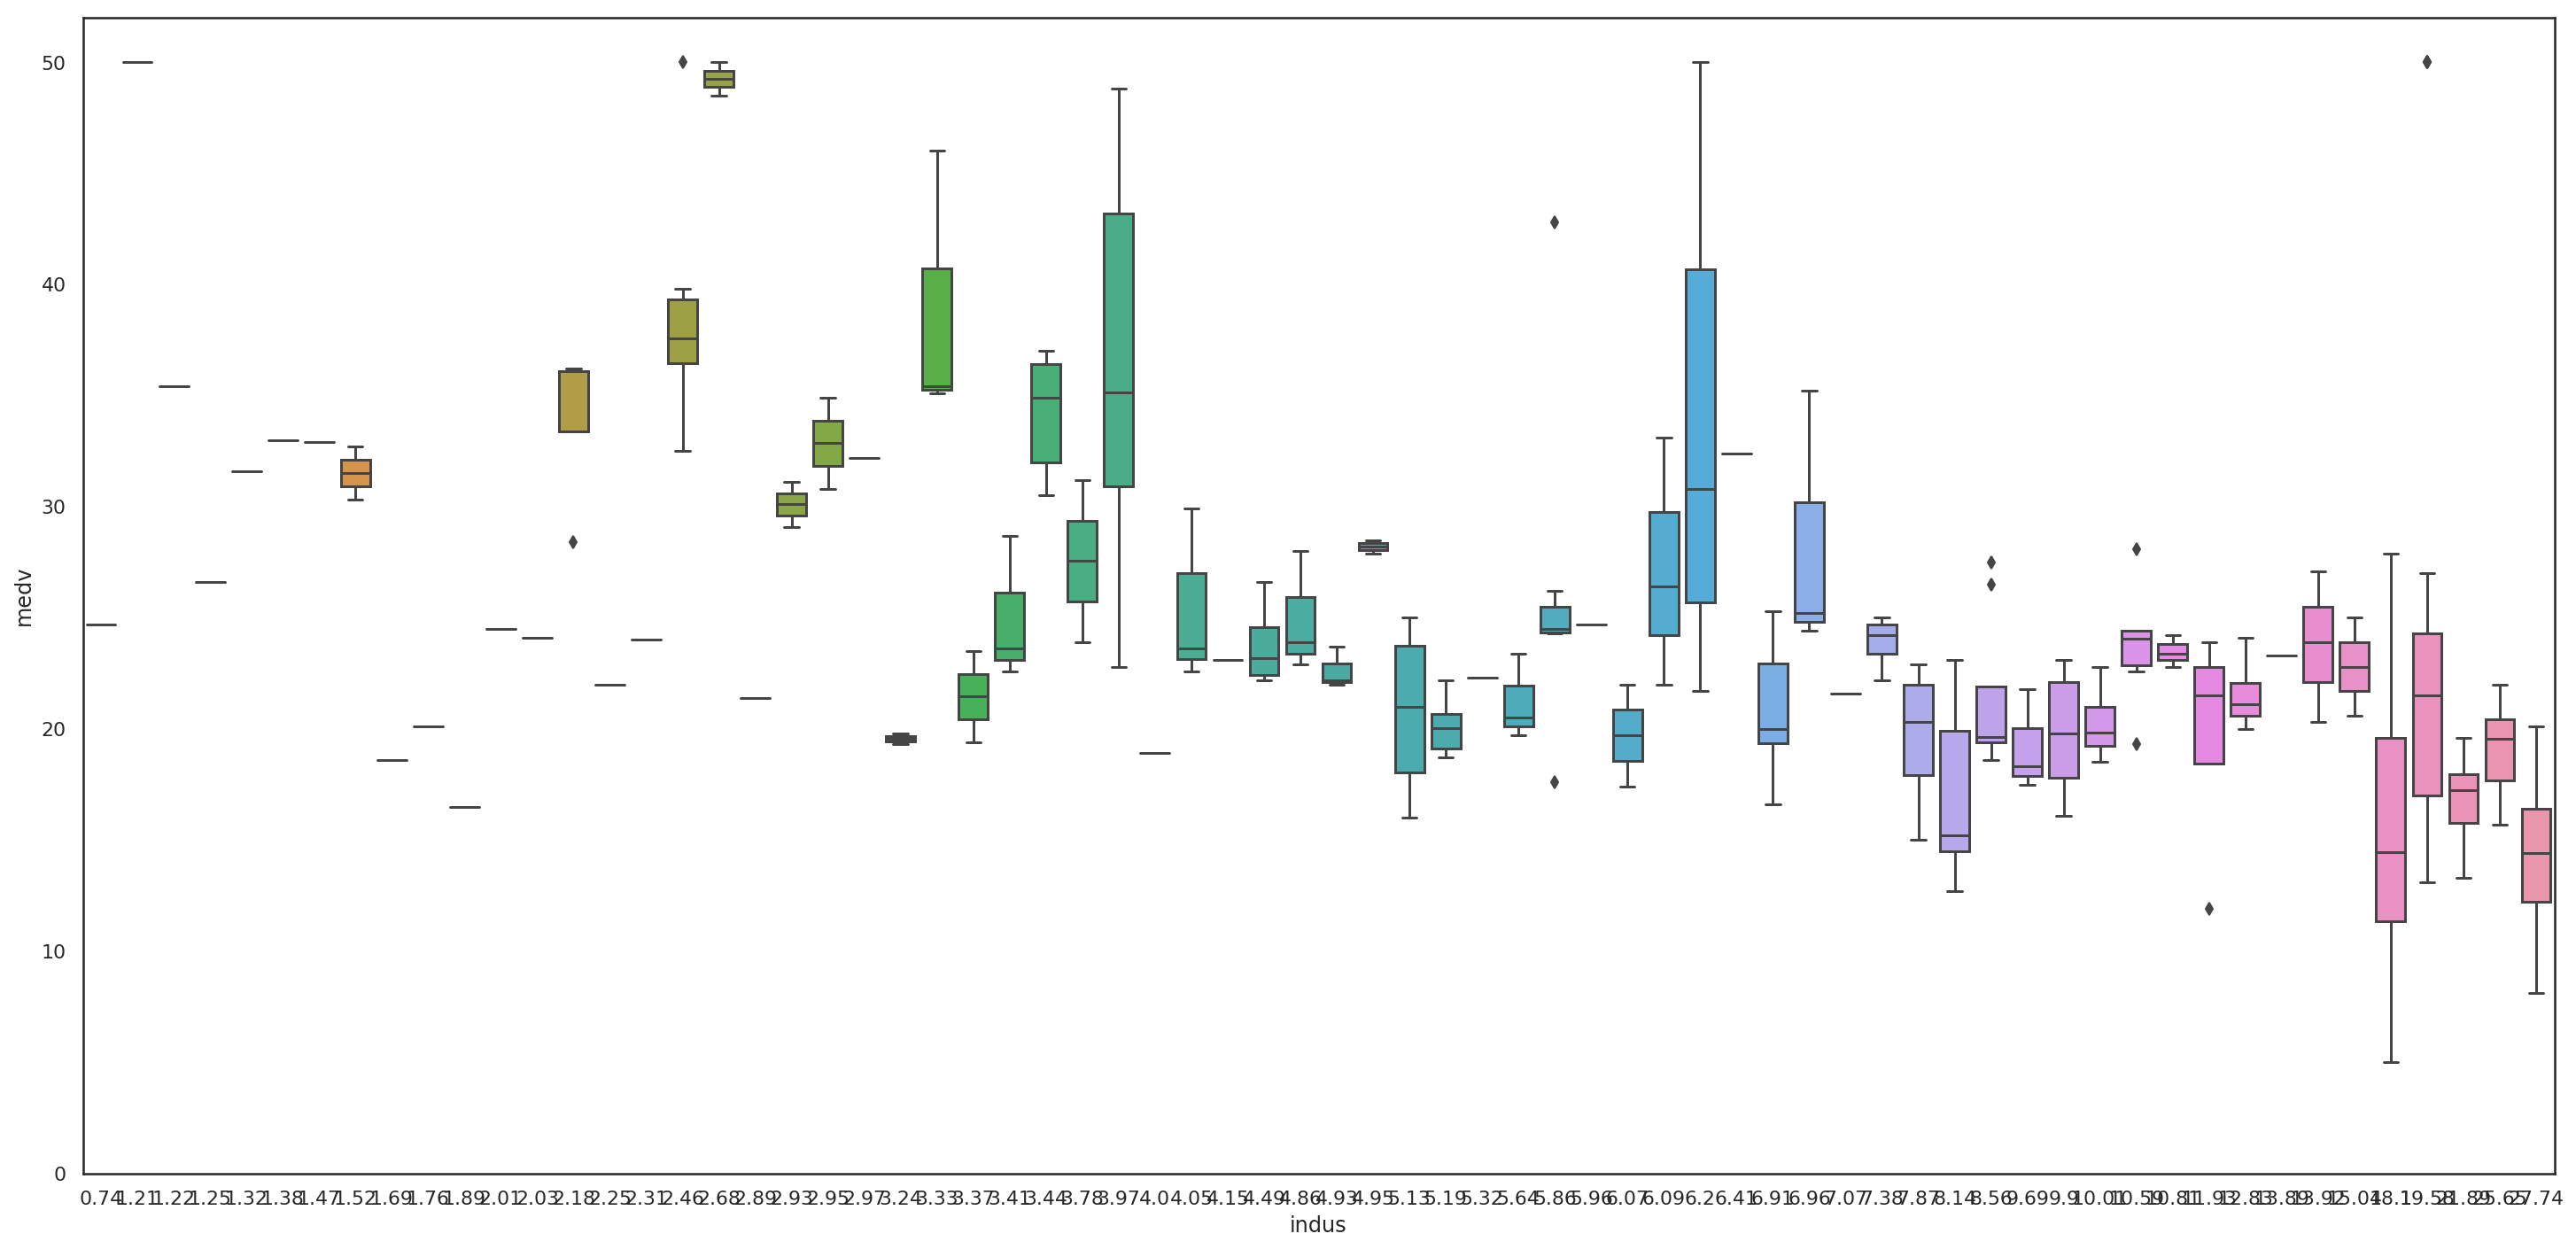

In [24]:
var = 'indus'
data = pd.concat([train['medv'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(25, 12))
fig = sns.boxplot(x=var, y="medv", data=data)
fig.axis(ymin=0, ymax=52);

W przypadku cechy 'indus' występują analogiczne zależności co w przypadku cechy 'ptratio'. 

Cecha 'indus' odnosi się do całych miast, będących skupiskiem regionów o różnej charaktetystyce. Mimo to widać tendencje do zmniejszania średniej wartości nieruchomości wraz ze zwiększonym udziałem przemysłu w rejonie.

Jednak widoczna jest pojedyncza anomalia w prawej górnej części wykresu regresji.

In [25]:
train = train.drop(train[(train['medv']>49.99) & (train['indus']>15)].index).reset_index(drop=True)

(-0.6141717904344736, 5.578789134079109e-35)


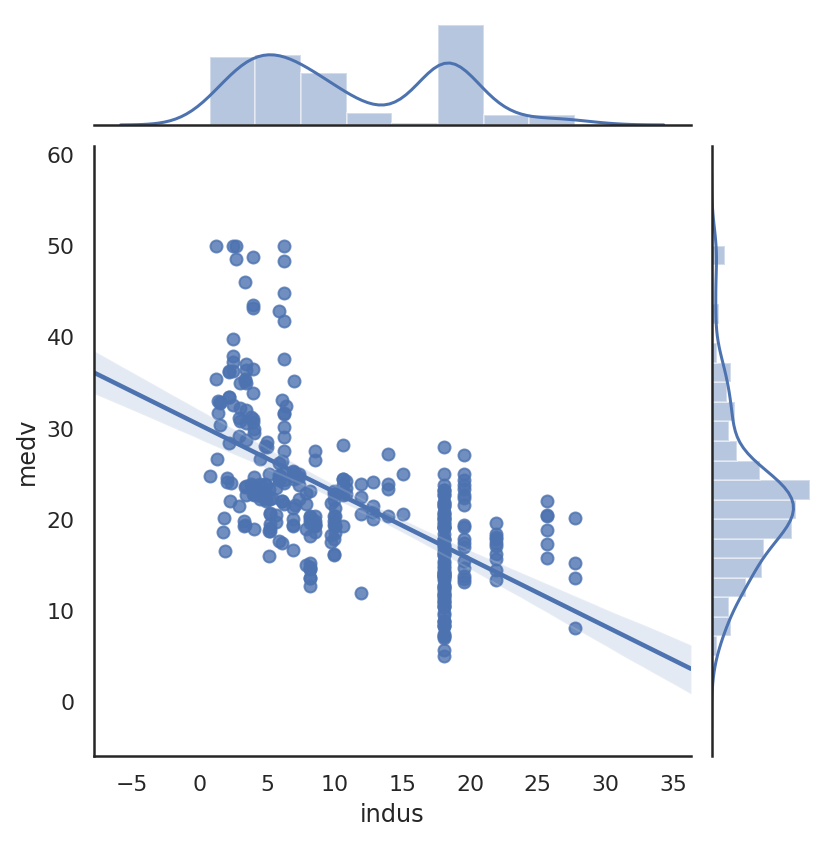

In [26]:
sns.jointplot(x=train['indus'], y=train['medv'], kind='reg');
print(pearsonr(train['indus'], train['medv']));

Zdecydowano się na usunięcie obserwacji odstającej, co poprawiło współczynnik korelacji o ponad 0.06.

### tax

(-0.5735517473407598, 9.8341291816132e-30)


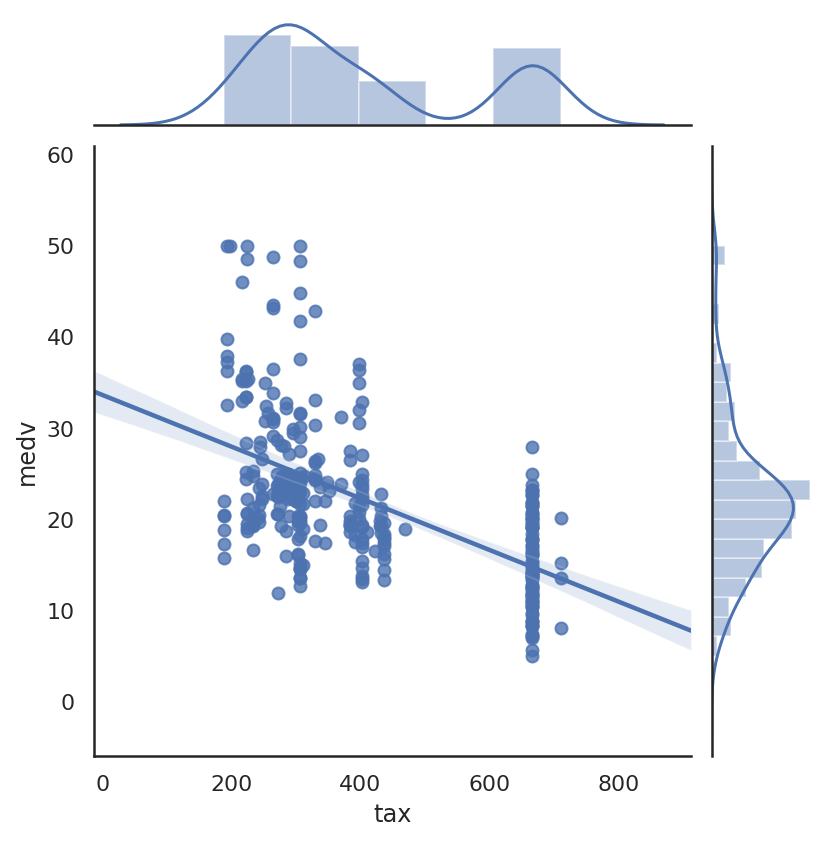

In [27]:
sns.jointplot(x=train['tax'], y=train['medv'], kind='reg');
print(pearsonr(train['tax'], train['medv']));

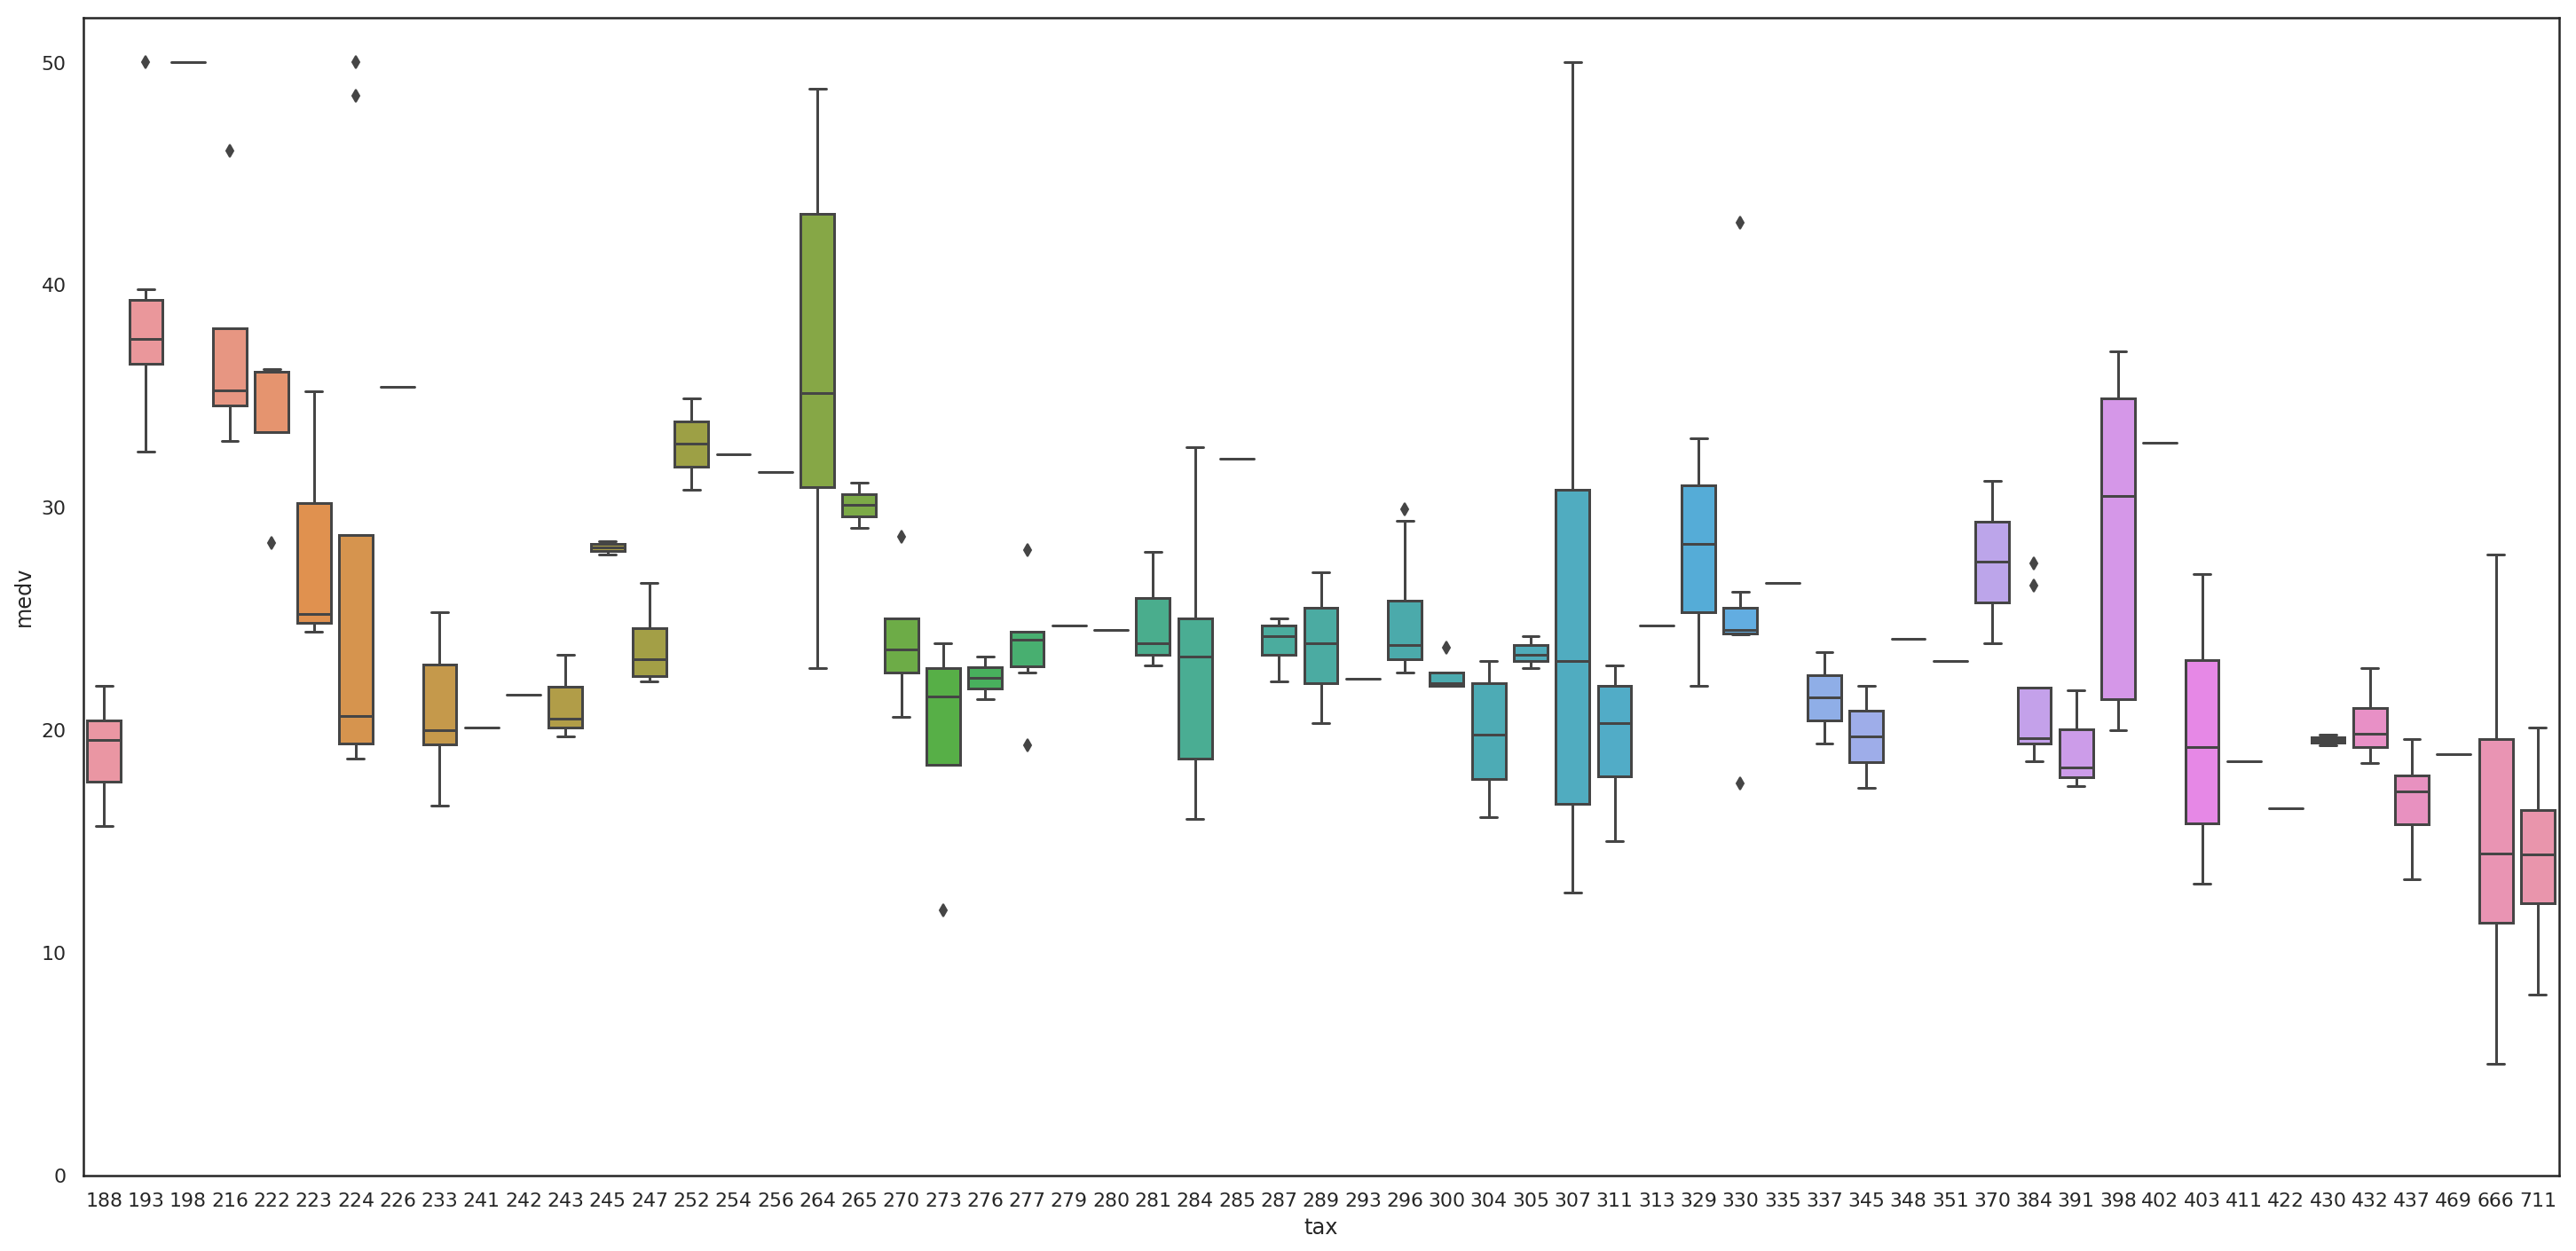

In [28]:
var = 'tax'
data = pd.concat([train['medv'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(25, 12))
fig = sns.boxplot(x=var, y="medv", data=data)
fig.axis(ymin=0, ymax=52);

Kolejny raz cechy określane są z dokładnością co do miast, a nie do rejonów. Jednak mimo to można dostrzec tendencje do zmniejszania się średniej wartości nieruchomości wraz ze zwiększaniem się wysokości podatku.

Żaden z przypadków nie wydaje się być odstający, dlatego nie zostaną podjęte żadne działania, mające na celu usunięcie anomalii.

# 4. Imputacja brakujących danych oraz wyczyszczenie danych

Podczas tego etapu dane zostaną dokładnie sprawdzone w celu znalezienia ewentualnych braków w poszczególnych kolumnach lub nieprawidłowościach wynikających z błędnej semantyki. 

In [30]:
# Combining Datasets
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.medv.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['medv'], axis=1, inplace=True)
print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

# Find Missing Ratio of Dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

Train data size is : (324, 12)
Test data size is : (173, 11)
Combined dataset size is : (497, 11)


,Missing Ratio


Krótkie sprawdzenie poprawności danych nie wykazało żadnych braków.

# 5. Optymalizacja danych 

Na tym etapie projektu przeprowadzona zostanie optymalizacja danych w celu poprawy ich rozkładu.

## 5.1 Optymalizacja rozkładu cechy predykowanej


 mu = 3.08 and sigma = 0.36



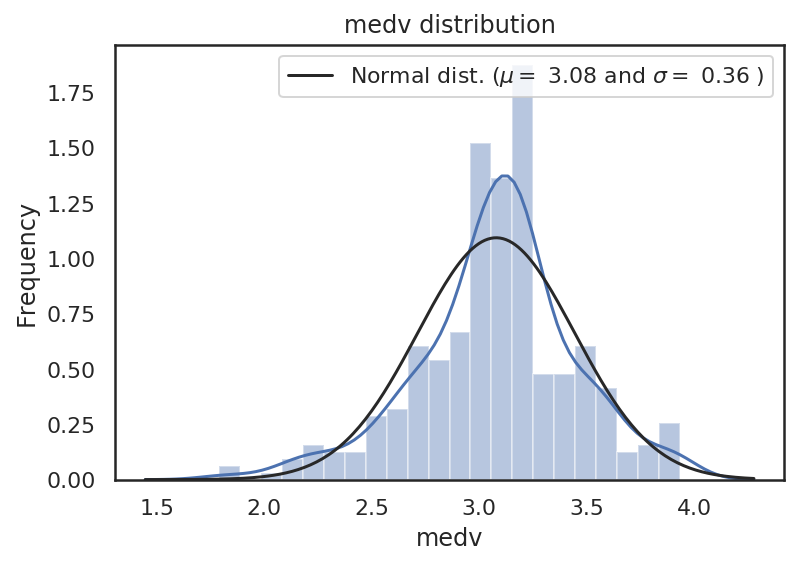

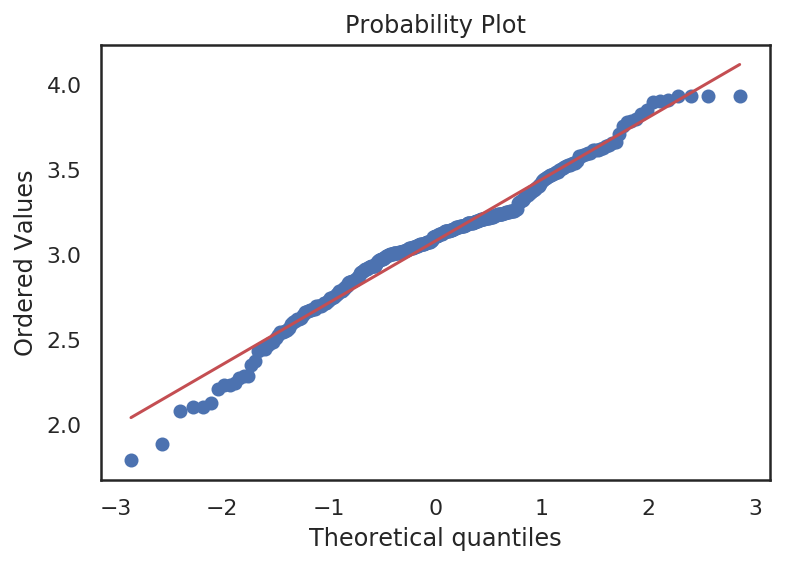

Skewness: -0.373671
Kurtosis: 0.852713


In [31]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["medv"] = np.log1p(train["medv"])

#Check the new distribution 
sns.distplot(train['medv'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['medv'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('medv distribution')

fig = plt.figure()
res = stats.probplot(train['medv'], plot=plt)
plt.show()

y_train = train.medv.values

print("Skewness: %f" % train['medv'].skew())
print("Kurtosis: %f" % train['medv'].kurt())

Można zauwazyć poprawę rozkładu średniej wartości nieruchomości po zastosowaniu funkcji log(1+x).
1. Wartość bezwględna skośności zmniejszyła się, jednak sam rozkład przesunięty jest teraz w prawo.
2. Kurtoza została zmniejszona, co oznacza, że rozkład nie jest już tak skupiony.

## 5.2 Optymalizacja rozkładów cech najbardziej wpływających na wartość nieruchomości

In [32]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['medv'], axis=1, inplace=True)
print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (324, 12)
Test data size is : (173, 11)
Combined dataset size is : (497, 11)


Na tym etapie połączone zostały dane zawarte w plikach train.csv oraz test.csv w celu ich wspólnej optymalizacji.

In [33]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: (skew(x.dropna()))).sort_values(ascending=False)
skewness = pd.DataFrame({'Positive skewed Features' :skewed_feats})
skewness.head(11)

,Positive skewed Features
crim,5.207267
zn,2.189268
rad,1.042004
dis,0.997628
lstat,0.900115
nox,0.760041
tax,0.702116
rm,0.592449
indus,0.336375
age,-0.572097


Można zauważyc, że rozkład niektórych cech nie jest zbliżony do normalnego. W szczególności rozkłady cech współczynnika przestępczości oraz proporcji powierzchni użytkowej są mocno zaburzone.

In [34]:
skewness = skewness[skewness > 0.8]
skewness = skewness.dropna()

from scipy.special import boxcox1p

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1

In [35]:
# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: (skew(x.dropna()))).sort_values(ascending=False)
skewness = pd.DataFrame({'Positive skewed Features' :skewed_feats})
skewness.head(11)

,Positive skewed Features
crim,1.552449
zn,1.242112
nox,0.760041
tax,0.702116
rad,0.688011
rm,0.592449
dis,0.416054
indus,0.336375
lstat,-0.006470
age,-0.572097


Na wybranych kolumnach zastosowane zostało przekształcenie Boxa-Coxa, które poprawiło rozkłady wyżej wymienionych cech.

In [36]:
train = all_data[:ntrain]
test = all_data[ntrain:]

Na koniec dane znowu zostały podzielone na zbiory trenujący oraz testowy, dzięki czemu projekt może wejść w ostatni etap - budowania modelu.

# 6. Budowanie modelu i predykcja